In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from util import all


In [78]:
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')


In [79]:
df = pd.read_csv('/Users/starsrain/2025_codeProject/fraudDetection_project0/AIML_Dataset.csv')

In [80]:

df.shape

(6362620, 11)

In [81]:
df.head(n = 5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [82]:
columns_names = df.columns
print(f'columns of this dataset are:{columns_names}')


columns of this dataset are:Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


In [83]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [84]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [85]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [86]:
actual_fraud = df['isFraud'].value_counts()[1]
total_fraud = df.shape[0]
fraud_percentage = round((actual_fraud/total_fraud)*100,3)
print(f'actual fraud percentage is {fraud_percentage}%')

actual fraud percentage is 0.129%


<function matplotlib.pyplot.show(close=None, block=None)>

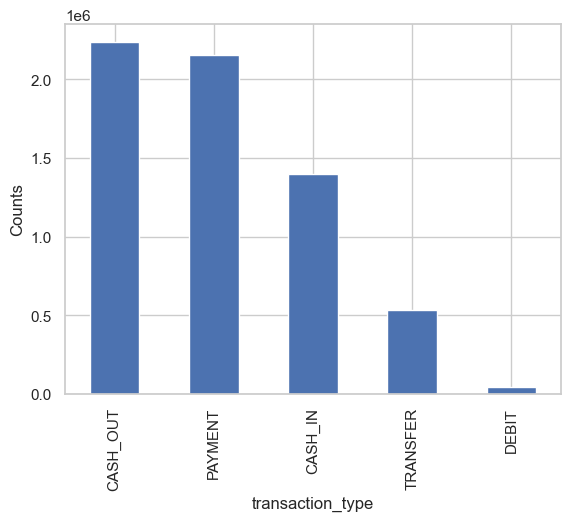

In [87]:
df['type'].value_counts().plot(kind = 'bar')
plt.xlabel("transaction_type")
plt.ylabel("Counts")
plt.show

<Axes: xlabel='type'>

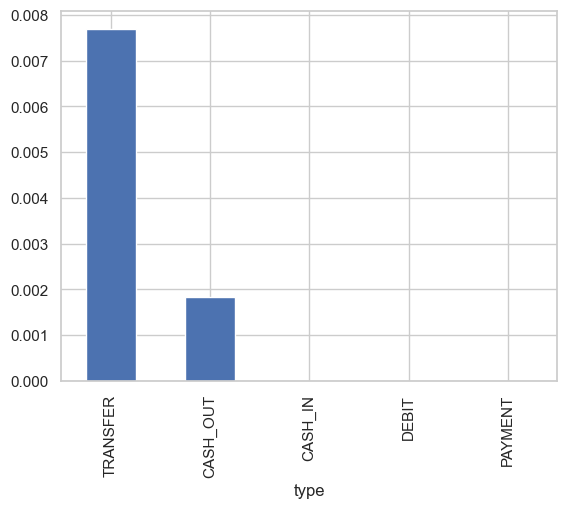

In [88]:
fraud_by_type = df.groupby(by = "type")["isFraud"].mean().sort_values(ascending=False)
fraud_by_type.plot(kind = "bar")

In [89]:
df["amount"].describe().astype(int)

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int64

In [90]:
df['amount'].median()


74871.94

In [91]:
from scipy.stats import skew

skewness_score = skew(df["amount"])
skewness_score_log = skew(np.log1p(df['amount']))
print(skewness_score)
print(f"skewness after log transformation is {skewness_score_log}")

30.99394217560623
skewness after log transformation is -0.5550181895761203


<Axes: xlabel='amount', ylabel='Count'>

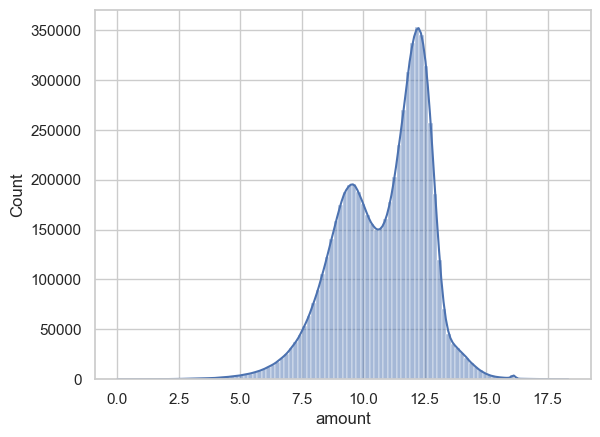

In [92]:
# plot visual before removing outliers
sns.histplot(np.log1p(df["amount"]), bins = 100, kde = True)


In [93]:
# IQR method
Q1 = df["amount"].quantile(0.25)
Q3 = df["amount"].quantile(0.75)
IQR = Q3-Q1
lower = Q1-1.5*IQR
upper = Q3+1.5*IQR
IQR_outliers = df[(df["amount"]<lower) | (df["amount"]>upper)]
print(f"the amount of outliers identified by IQR method is {len(IQR_outliers)}")

the amount of outliers identified by IQR method is 338078


In [94]:
iqr_clean = df[(df["amount"] >= lower) & (df["amount"]<= upper)]
iqr_clean.shape

(6024542, 11)

In [95]:
iqr_clean_skewness = skew(np.log1p(iqr_clean["amount"]))
print(f"skewness after iqr method is {iqr_clean_skewness}")

skewness after iqr method is -0.7480690288197432


<Axes: xlabel='amount', ylabel='Count'>

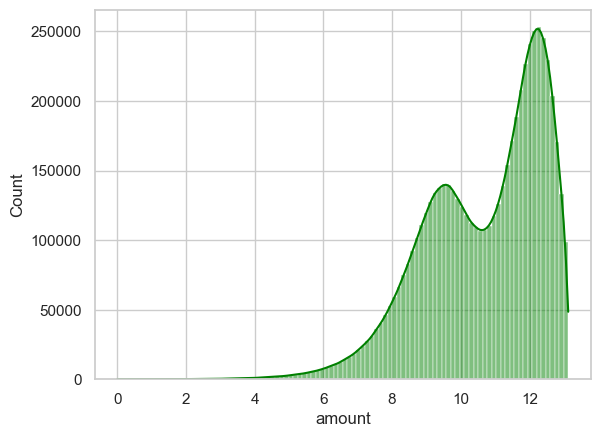

In [96]:
# new graph after removing the outliers
sns.histplot(np.log1p(iqr_clean["amount"]), bins = 100, kde = True, color = "green")

In [97]:
from sklearn.ensemble import IsolationForest
#prepare some features, Start with a fresh slate called df_encoded
df_encoded = pd.get_dummies(df, columns=['type'], drop_first=True)
df_encoded["diffOrig"] = df_encoded["oldbalanceOrg"] - df_encoded["newbalanceOrig"]
df_encoded["diffDest"] = df_encoded["newbalanceDest"] - df_encoded["oldbalanceDest"]

iso = IsolationForest(contamination = 0.01, random_state= 37)
features = ["amount","diffOrig","diffDest"] + [col for col in df_encoded.columns if col.startswith("type_")]
df_encoded["anomaly"] = iso.fit_predict(df_encoded[features])

df_encoded.head(10)

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,diffOrig,diffDest,anomaly
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0,False,False,True,False,9839.64,0.00,1
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0,False,False,True,False,1864.28,0.00,1
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0,False,False,False,True,181.00,0.00,1
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,True,False,False,False,181.00,-21182.00,1
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0,False,False,True,False,11668.14,0.00,1
5,1,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0,False,False,True,False,7817.71,0.00,1
6,1,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0,False,False,True,False,7107.77,0.00,1
7,1,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,False,False,True,False,7861.64,0.00,1
8,1,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0,False,False,True,False,2671.00,0.00,1
9,1,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0,False,True,False,False,5337.77,-1549.21,1


In [98]:
# check how many rows are classified as anomalies according to IsoForest
iso_outliers = df_encoded[df_encoded["anomaly"] == -1]
print(len(iso_outliers))

63294


<Axes: xlabel='amount', ylabel='Count'>

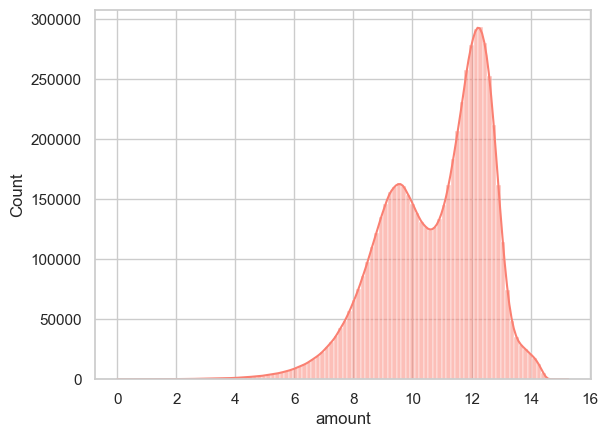

In [99]:
iso_clean = df_encoded[df_encoded["anomaly"] == 1].drop(columns=["anomaly"])
sns.histplot(data = np.log1p(iso_clean["amount"]), kde = True, bins = 100, color = "salmon")

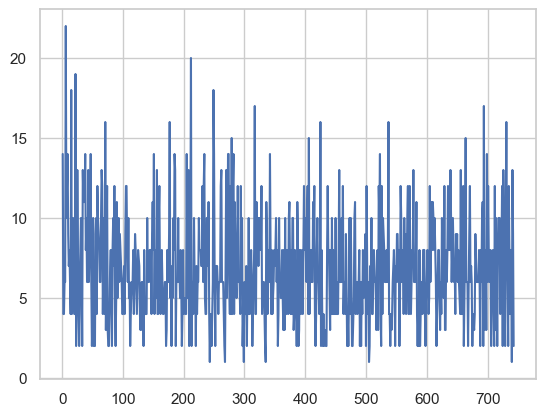

In [100]:
# prepare to plot step
fraud_per_step =iso_clean[iso_clean["isFraud"] == 1]["step"].value_counts().sort_index()
plt.plot(fraud_per_step.index, fraud_per_step.values, label = "Fraud per day")
plt.show()


In [101]:
iso_clean.drop(columns = "step", inplace= True)


In [102]:
top_sender = iso_clean["nameOrig"].value_counts().head(10)
top_sender

nameOrig
C1530544995    3
C2051359467    3
C2098525306    3
C1462946854    3
C1999539787    3
C1832548028    3
C1784010646    3
C363736674     3
C1677795071    3
C724452879     3
Name: count, dtype: int64

In [103]:
top_receiver = iso_clean['nameDest'].value_counts().head(10)
top_receiver

nameDest
C1286084959    104
C985934102     102
C451111351      96
C2083562754     93
C977993101      92
C1789550256     91
C1899073220     91
C665576141      91
C248609774      91
C1590550415     91
Name: count, dtype: int64

In [40]:
fraud_users = iso_clean[iso_clean["isFraud"] == 1]["nameOrig"].value_counts().head(10)
fraud_users

nameOrig
C1305486145    1
C317779855     1
C488038887     1
C1648943042    1
C755656980     1
C1267328802    1
C258213312     1
C1640703547    1
C1127265876    1
C1064034527    1
Name: count, dtype: int64

In [104]:
fraud_df= df[df["type"].isin(["TRANSFER","CASH_OUT"])]
fraud_df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


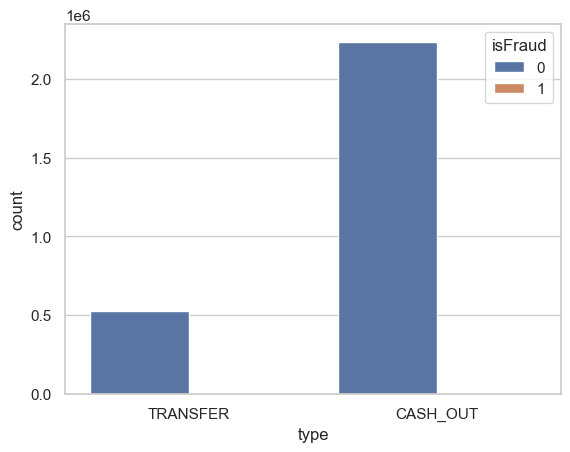

In [105]:
sns.countplot(data = fraud_df, x = "type", hue = "isFraud")
plt.show()

In [106]:
corr_features = ["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest","isFraud"]
corr = iso_clean[corr_features].corr()


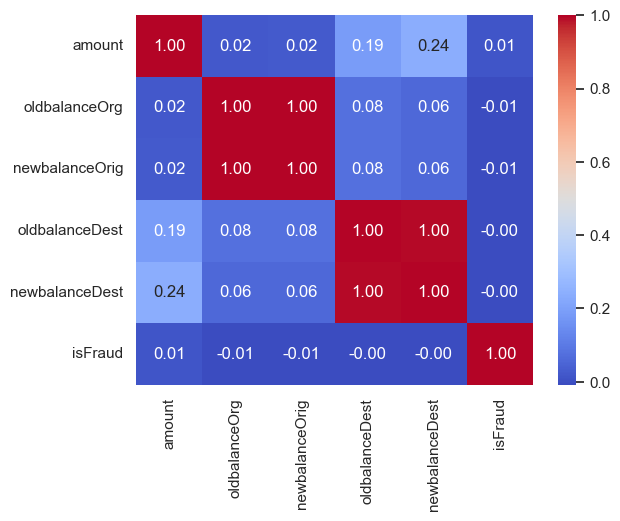

In [107]:
sns.heatmap(corr, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.show()

In [120]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [153]:
# use iso_clean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder



In [109]:
iso_clean.columns

Index(['amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
       'diffOrig', 'diffDest'],
      dtype='object')

In [121]:
cleaned_model = iso_clean.drop(columns = ["nameOrig","nameDest","isFlaggedFraud"], axis = 1)
categorical_features = ["type_CASH_OUT","type_DEBIT","type_PAYMENT","type_TRANSFER"]
numerical_features = ["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]

In [122]:
y = cleaned_model["isFraud"]
X = cleaned_model.drop(columns = ["isFraud"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 37, stratify = y)

In [123]:
X

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,diffOrig,diffDest
0,9839.64,170136.00,160296.36,0.00,0.00,False,False,True,False,9839.64,0.00
1,1864.28,21249.00,19384.72,0.00,0.00,False,False,True,False,1864.28,0.00
2,181.00,181.00,0.00,0.00,0.00,False,False,False,True,181.00,0.00
3,181.00,181.00,0.00,21182.00,0.00,True,False,False,False,181.00,-21182.00
4,11668.14,41554.00,29885.86,0.00,0.00,False,False,True,False,11668.14,0.00
...,...,...,...,...,...,...,...,...,...,...,...
6362609,258355.42,258355.42,0.00,25176.67,283532.09,True,False,False,False,258355.42,258355.42
6362610,63416.99,63416.99,0.00,0.00,0.00,False,False,False,True,63416.99,0.00
6362611,63416.99,63416.99,0.00,276433.18,339850.17,True,False,False,False,63416.99,63416.99
6362614,339682.13,339682.13,0.00,0.00,0.00,False,False,False,True,339682.13,0.00


In [124]:
# Data Preprocessing
Preprocessor = ColumnTransformer(
    transformers = [
        ("num", StandardScaler(), numerical_features),
        ("cat", "passthrough",categorical_features)
    ],
    remainder = "drop"
)


In [125]:
pipeline = Pipeline(
 [
     ("prep", Preprocessor),
     ("classifier", LogisticRegression(class_weight = "balanced", max_iter = 1000, random_state = 37))
 ]   
)

In [126]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat', 'passthrough',
                                                  ['type_CASH_OUT',
                                                   'type_DEBIT', 'type_PAYMENT',
                                                   'type_TRANSFER'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=37))])

In [130]:
y_pred =pipeline.predict(X_test)

In [131]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96   1258879
           1       0.01      0.99      0.02       987

    accuracy                           0.92   1259866
   macro avg       0.50      0.95      0.49   1259866
weighted avg       1.00      0.92      0.96   1259866



In [132]:
confusion_matrix(y_test, y_pred)

array([[1155349,  103530],
       [     12,     975]])

In [134]:
pipeline.score(X_test, y_test)
# End of Logistic regression

0.9178150692216474

In [136]:
write_pickle(pipeline, path_in = "./", file_name = "simple_logistic_regression")

### Try Random Forest


In [141]:
from sklearn.ensemble import RandomForestClassifier
pipeline2 = Pipeline(
 [
     ("prep", Preprocessor),
     ("classifier", RandomForestClassifier(n_estimators = 100, random_state = 37))
 ]   
)

In [142]:
pipeline2.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat', 'passthrough',
                                                  ['type_CASH_OUT',
                                                   'type_DEBIT', 'type_PAYMENT',
                                                   'type_TRANSFER'])])),
                ('classifier', RandomForestClassifier(random_state=37))])

In [143]:
y_pred_rf = pipeline2.predict(X_test)
y_pred_proba_rf = pipeline2.predict_proba(X_test)[:, 1]

In [ ]:
print(confusion_matrix(y_test, y_pred_rf))
# way less false positive (from 100k down to 53)

[[1258826      53]
 [    358     629]]


In [147]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1258879
           1       0.92      0.64      0.75       987

    accuracy                           1.00   1259866
   macro avg       0.96      0.82      0.88   1259866
weighted avg       1.00      1.00      1.00   1259866



### try gradient boosting


In [149]:
from sklearn.ensemble import GradientBoostingClassifier
pipeline3 = Pipeline(
 [
     ("prep", Preprocessor),
     ("classifier", GradientBoostingClassifier(n_estimators = 100,learning_rate = 0.1, max_depth = 3, random_state = 37))
 ]   
)

In [150]:
pipeline3.fit(X_train, y_train)
y_pred_gb = pipeline3.predict(X_test)

In [151]:
print(confusion_matrix(y_test, y_pred_gb))

[[1258868      11]
 [    952      35]]


In [152]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1258879
           1       0.76      0.04      0.07       987

    accuracy                           1.00   1259866
   macro avg       0.88      0.52      0.53   1259866
weighted avg       1.00      1.00      1.00   1259866



In [155]:
gb_precision = precision_score(y_test, y_pred_gb)
print(f"Gradient Boosting Classifier's precision score is {gb_precision}")


Gradient Boosting Classifier's precision score is 0.7608695652173914


### Try XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV
"""
暂时别run, 花太久了run不完
"""
param_grid = {
      'classifier__n_estimators': [100, 200],
      'classifier__max_depth': [None, 10, 20],
      'classifier__class_weight': [None, 'balanced']
  }
grid_search = GridSearchCV(pipeline2, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)